In [1]:
import numpy as np
import torch
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn
import sys
seaborn.set()

import warnings
warnings.filterwarnings("ignore")

import reservoir
import reckernel
import kuramoto
%load_ext autoreload
%autoreload 2
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Data generation

In [2]:
L = 22 / (2 * np.pi)  # length
N = 100  # space discretization step
dt = 0.25  # time discretization step
N_train = 10000
N_test = 10000
N_init = 1000  # remove the initial points
tend = (N_train + N_test) * dt + N_init

dns = kuramoto.KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()
u = dns.uu[N_init:] / np.sqrt(N)
[u_train, u_test, _] = np.split(u, [N_train, N_train+N_test], axis=0)

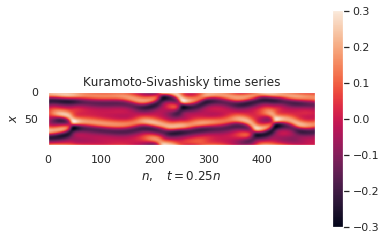

In [3]:
N_plot = 500
u_plot = u[:N_plot,:]

plt.figure()
plt.imshow(u_plot.T)
plt.colorbar()
plt.grid(b=None)
plt.xlabel(r"$n, \quad t={:}n$".format(dt))
plt.ylabel(r"$x$")
plt.title("Kuramoto-Sivashisky time series");

# Stability for Reservoir Computing

In [4]:
input_data = torch.from_numpy(u_train).to(device)
input_len = 100
input_data = input_data[:input_len, :]

n_input = 1 # number of time series
input_len, input_dim = input_data.shape # time steps t
input_scale = 0.01  # variance of input
res_scale = 0.8 # variance of reservoir

n_res = 1000
torch.manual_seed(1)
initial_state1 = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf')
X1 = model.forward(input_data, initial_state=initial_state1).to(device)

torch.manual_seed(2)
initial_state2 = torch.randn(n_res).to(device) / np.sqrt(n_res)
model = reservoir.ESN(input_dim, res_size=n_res, res_scale=res_scale, input_scale=input_scale, f='erf')
X2 = model.forward(input_data, initial_state=initial_state2).to(device)

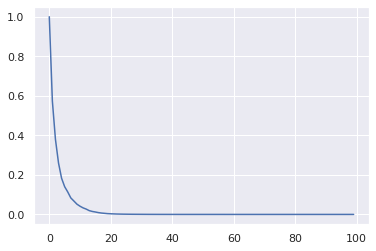

In [5]:
diff2 = torch.mean(torch.abs(X2 - X1)**2, axis=1).cpu()
plt.plot(diff2 / diff2[0]);

# Stability for Recurrent Kernels

In [19]:
input_data = torch.from_numpy(u_train).to(device)
input_len = 150
input_data = input_data[:input_len, :]

n_input = 1 # number of time series
input_len, input_dim = input_data.shape # time steps t
input_scale = 0.01  # variance of input
res_scale = 0.8 # variance of reservoir

model = reckernel.RecKernel(function='arcsin', res_scale=res_scale, input_scale=input_scale, n_iter=50)
dist2 = model.test_stability(input_data).cpu()

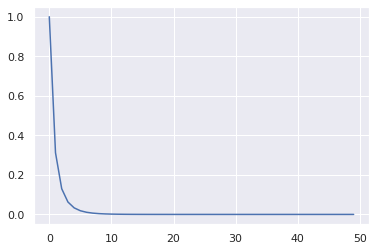

In [20]:
plt.plot(dist2/dist2[0]);